# Imports

In [1]:
import shap

import pandas  as pd
import numpy   as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn   import metrics
from lightgbm  import LGBMClassifier
from tabulate  import tabulate
from ucimlrepo import fetch_ucirepo

from scipy.stats               import ks_2samp
from sklearn.inspection        import permutation_importance
from sklearn.calibration       import calibration_curve
from sklearn.model_selection   import learning_curve, cross_validate, train_test_split, StratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector

/home/junior/Documentos/palestra_scti/venv/lib64/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Functions

In [2]:
def ks_score(y_true, y_prob):
    
    pos_prob = y_prob[y_true == 1]
    neg_prob = y_prob[y_true == 0]
    
    if len(pos_prob) == 0 or len(neg_prob) == 0:
        return 0.0
    
    result = ks_2samp(pos_prob, neg_prob)
    
    return result.statistic

ks_scorer = metrics.make_scorer(ks_score, greater_is_better=True, response_method="predict_proba")

def get_classifier_metrics(y, target):
    
    return {
        'Balanced Accuracy': metrics.balanced_accuracy_score(y[target], y[f'{model_name}_pred']),
        'Precision': metrics.precision_score(y[target], y[f'{model_name}_pred']),
        'Recall': metrics.recall_score(y[target], y[f'{model_name}_pred']),
        'F1': metrics.f1_score(y[target], y[f'{model_name}_pred']),
        'AUC': metrics.roc_auc_score(y[target], y[f'{model_name}_prob']),
        'KS': ks_score(y[target], y[f'{model_name}_prob']),
        'Brier': metrics.brier_score_loss(y[target], y[f'{model_name}_prob'])
    }

def plot_learning_curve(model, X, y, target, scoring, cv=5):

    splitter = StratifiedKFold(cv, shuffle=True, random_state=42)
    
    train_sizes_abs, train_scores, val_scores = learning_curve(
        model, X, y[target],
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=splitter,
        scoring=scoring
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    # plt.figure(figsize=(10, 6))
    plt.plot(train_sizes_abs, train_scores_mean, 'o-', color='r', label='Train')
    plt.fill_between(
        train_sizes_abs, train_scores_mean - train_scores_std, 
        train_scores_mean + train_scores_std, alpha=0.1, color='r')

    plt.plot(train_sizes_abs, val_scores_mean, 'o-', color='b', label='Validation')
    plt.fill_between(
        train_sizes_abs, val_scores_mean - val_scores_std,
        val_scores_mean + val_scores_std, alpha=0.1, color='b')

    plt.title("Learning Curve")
    plt.xlabel("Train Size")
    plt.ylabel(f"{scoring}")
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_calibration_curve(y, target, n_bins=10, strategy='uniform'):

    prob_true, prob_pred = calibration_curve(y[target], y["prob"], n_bins=n_bins, strategy=strategy)

    # plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Model')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated', color='gray')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Frequency')
    plt.title('Calibration Curve')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_feature_importance(model):

    feature_names = model.feature_name_ if hasattr(model, 'feature_name_') else model.feature_names_ # for catboost
    
    df_imp = pd.DataFrame(model.feature_importances_, feature_names).reset_index()
    df_imp.columns = ["Variable", "Importance"]
    df_imp = df_imp.sort_values("Importance", ascending=False)

    sns.barplot(x="Importance", y="Variable", color="#006e9cff", data=df_imp[:20])

    plt.title(f"Importance of Variables")
    plt.show()

def plot_permutation_importance(model, features, X, y, scoring):

    permu_results = permutation_importance(model, X[features], y, scoring=scoring, n_repeats=5, random_state=42)

    sorted_importances_idx = permu_results.importances_mean.argsort()
    
    df_results = pd.DataFrame(permu_results.importances[sorted_importances_idx].T, columns=X.columns[sorted_importances_idx])
    
    ax = df_results.plot.box(vert=False, whis=10, patch_artist=True, boxprops={'facecolor':'skyblue', 'color':'blue'})
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel(f"Decrease in {scoring}")

    plt.show()

def plot_shap_summary(model, features, X):

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X[features])
    
    shap.summary_plot(shap_values, X[features])

def get_cv_metrics(cv_results):

    acc = cv_results['test_accuracy'].mean()
    balanced_acc = cv_results['test_balanced_accuracy'].mean()
    precision = cv_results['test_precision'].mean()
    recall = cv_results['test_recall'].mean()
    f1 = cv_results['test_f1'].mean()
    auc = cv_results['test_roc_auc'].mean()
    ks = cv_results['test_ks'].mean()
    brier = cv_results['test_brier'].mean() * -1
    
    data = [[acc, balanced_acc, precision, recall, f1, auc, ks, brier]]
    headers = ["Accuracy", "Balanced Accuracy", "Precision", "Recall", "F1", "ROC AUC", "KS", "Brier"]
    
    print(tabulate(data, headers=headers, tablefmt="plain"))

def get_metrics(y, target_name):

    target, pred, prob = y[target_name], y['pred'], y['prob']
    
    acc = metrics.accuracy_score(target, pred)
    balanced_acc = metrics.balanced_accuracy_score(target, pred)
    precision = metrics.precision_score(target, pred)
    recall = metrics.recall_score(target, pred)
    f1 = metrics.f1_score(target, pred)
    auc = metrics.roc_auc_score(target, prob)
    ks = ks_score(target, prob)
    brier = metrics.brier_score_loss(target, prob)

    data = [[acc, balanced_acc, precision, recall, f1, auc, ks, brier]]
    headers = ["Accuracy", "Balanced Accuracy", "Precision", "Recall", "F1", "ROC AUC", "KS", "Brier"]
    
    print(tabulate(data, headers=headers, tablefmt="plain"))

def prob_to_score(probs, min_score=0, max_score=1000, inverse=False):
    
    """
    Convert probabilities to scores in intervals [min_score, max_score].

    Args:
        probs (array-like): List of probabilities between 0 and 1.
        min_score (int): Scor min (default=1).
        max_score (int): Scor max (default=1000).
        inverse (bool): If True, probability is high => score is lower (ex: risk).

    Returns:
        np.array: Scores between min_score and max_score.
    """

    probs = np.asarray(probs)

    if inverse:
        probs = 1 - probs
    
    scores = min_score + (max_score - min_score) * probs
    
    return np.round(scores).astype(int)

def calc_rating_limits(y, n_ratings=5, min_score=0, max_score=1000):
    
    scores = np.asarray(y)
    
    quantiles = np.linspace(0, 1, n_ratings + 1)[1:-1]
    inner_thresholds = np.quantile(scores, quantiles)
    
    thresholds = [min_score] + inner_thresholds.tolist() + [max_score]

    return thresholds

def apply_ratings(y, thresholds, labels=None):
  
    return pd.cut(y, bins=thresholds, labels=labels, include_lowest=True)

def plot_rating_distribution(y, model_name, target):

    """
    Plot the distribution of ratings.

    Args:
        df (pd.DataFrame): DataFrame with the rating and score.
    """
    
    y.groupby([f'{model_name}_rating'], observed=True)[target].count().plot(kind='bar')
    
    plt.title(f'Rating Distribution - {model_name}')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

def plot_rating(y, model_name, target):
    
    """
    Plot the average score for each rating.

    Args:
        df (pd.DataFrame): DataFrame with the rating and score.
    """
    
    y.groupby([f'{model_name}_rating'], observed=True)[target].mean().plot(kind='bar')
    
    plt.title(f'Rating vs Target - {model_name}')
    plt.xlabel('Rating')
    plt.ylabel('Average Target')
    plt.xticks(rotation=45)
    plt.show()

In [3]:
random_state = 42
np.random.seed(random_state)

# Dataset

In [4]:
# df = fetch_ucirepo(id=350)

# X = df.data.features
# df_aux = df.variables
# X.columns = df_aux.loc[~df_aux['name'].isin(['ID', 'Y']), 'description'].values

# y = df.data.targets
# y.columns = ['target']

# df = pd.concat([X, y], axis=1)
# df.to_csv('../data/database.csv', index=False)

In [5]:
df = pd.read_csv('../data/database.csv')

X = df.iloc[:, :-1]
y = df.iloc[:, -1:]

## Data Types

In [6]:
X.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
dtype: object

## Data Dimension

In [7]:
X.shape

(30000, 23)

In [8]:
y.shape

(30000, 1)

In [9]:
y['target'].value_counts(1)

target
0    0.7788
1    0.2212
Name: proportion, dtype: float64

## Missing Values

In [11]:
X.isna().mean()

LIMIT_BAL    0.0
SEX          0.0
EDUCATION    0.0
MARRIAGE     0.0
AGE          0.0
PAY_0        0.0
PAY_2        0.0
PAY_3        0.0
PAY_4        0.0
PAY_5        0.0
PAY_6        0.0
BILL_AMT1    0.0
BILL_AMT2    0.0
BILL_AMT3    0.0
BILL_AMT4    0.0
BILL_AMT5    0.0
BILL_AMT6    0.0
PAY_AMT1     0.0
PAY_AMT2     0.0
PAY_AMT3     0.0
PAY_AMT4     0.0
PAY_AMT5     0.0
PAY_AMT6     0.0
dtype: float64

## Training and Testing Database

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, stratify=y)

# Feature Engineering

## Categorical Encoders

Bibliotecas:

- [Feature Engine](https://feature-engine.trainindata.com/en/latest/#)
- [Category Encoders](https://contrib.scikit-learn.org/category_encoders/)
- [Feature Tools](https://featuretools.alteryx.com/en/stable/)

- **One Hot Encoder**
- **Count Frequency Encoder**
- **Ordinal Encoder**
- **Mean Encoder**

## Data Balancing

Bibliotecas:
- [Imbalnced Learn](https://imbalanced-learn.org/stable/introduction.html)

- Undersampling
- Oversampling

## Feature Selection

Bibliotecas:

- [Scikit-Learn](https://scikit-learn.org/stable/)
- [Feature Engine](https://feature-engine.trainindata.com/en/latest/)
- [skforecast](https://skforecast.org/0.17.0/)

In [87]:
# sfs = SequentialFeatureSelector(
#     estimator=LGBMClassifier(verbosity=-1), 
#     n_features_to_select='auto',
#     direction='forward', # o número de features vai crescendo
#     scoring='roc_auc', 
#     cv=3, 
#     n_jobs=-1
# )

# sfs.fit(X_train, y_train)

In [14]:
selected_columns = ['LIMIT_BAL', 'EDUCATION', 'PAY_0', 'PAY_2', 'PAY_4', 'PAY_5', 'BILL_AMT1', 'BILL_AMT3', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT6']

# Machine Learning

## Baseline Model

Bibliotecas:

- [Scikit-Learn](https://scikit-learn.org/stable/)
- [XGBoost](https://xgboost.readthedocs.io/en/stable/)
- [LightGBM](https://lightgbm.readthedocs.io/en/stable/)
- [CatBoost](https://catboost.ai/)

## Feature Selection Model

Bibliotecas:

- [Acikit-Learn](https://scikit-learn.org/stable/api/sklearn.feature_selection.html#module-sklearn.feature_selection)
- [Boruta](https://github.com/scikit-learn-contrib/boruta_py?tab=readme-ov-file)
- [BorutaShap](https://github.com/Ekeany/Boruta-Shap)
- [Feature Engine](https://feature-engine.trainindata.com/en/latest/#feature-selection)

In [15]:
lgbm = LGBMClassifier(verbosity=-1)
lgbm.fit(X_train[selected_columns], y_train['target'])

y_train['pred'] = lgbm.predict(X_train[selected_columns])
y_train['prob'] = lgbm.predict_proba(X_train[selected_columns])[:, 1]

y_test['pred'] = lgbm.predict(X_test[selected_columns])
y_test['prob'] = lgbm.predict_proba(X_test[selected_columns])[:, 1]

In [16]:
cv_results = cross_validate(
    LGBMClassifier(verbosity=-1), 
    X_train[selected_columns], 
    y_train['target'],
    n_jobs=-1,
    cv=5,
    scoring={
        'accuracy': 'accuracy',
        'balanced_accuracy': 'balanced_accuracy', 
        'precision': 'precision', 
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc',
        'ks': ks_scorer,
        'brier': 'neg_brier_score'
    }
)

### Metrics

In [17]:
get_cv_metrics(cv_results)

  Accuracy    Balanced Accuracy    Precision    Recall        F1    ROC AUC        KS     Brier
  0.819722             0.658708      0.66705  0.369921  0.475628   0.773084  0.429198  0.135758


In [92]:
get_metrics(y_test, 'target')

  Accuracy    Balanced Accuracy    Precision    Recall        F1    ROC AUC        KS     Brier
  0.820833             0.656868     0.677215  0.362849  0.472522   0.774431  0.426102  0.134813


### Calibration Curve

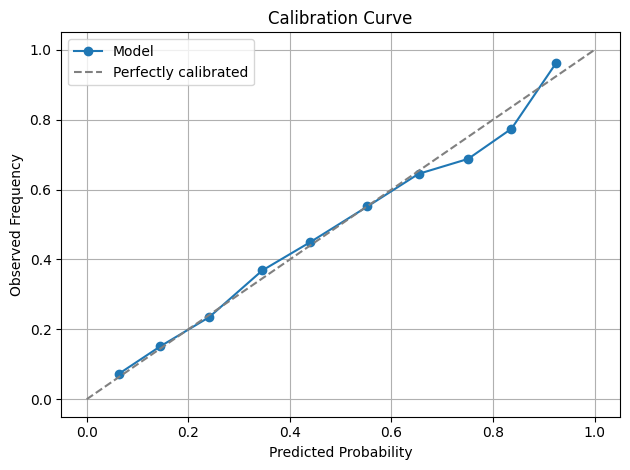

In [18]:
plot_calibration_curve(y_test, 'target')

### Learning Curve

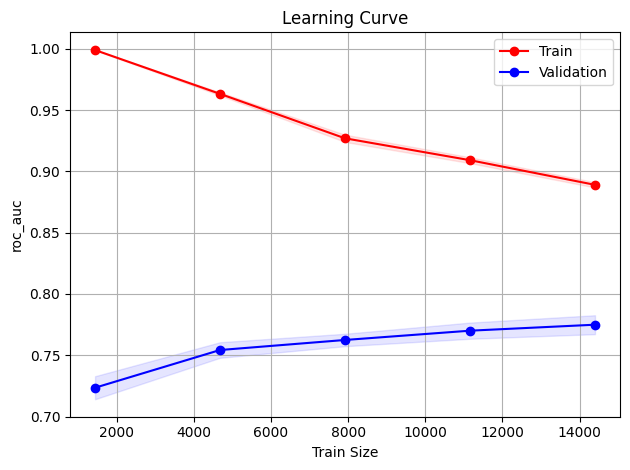

In [19]:
plot_learning_curve(lgbm, X_train[selected_columns], y_train, 'target', scoring='roc_auc', cv=5)

### Feature Importance

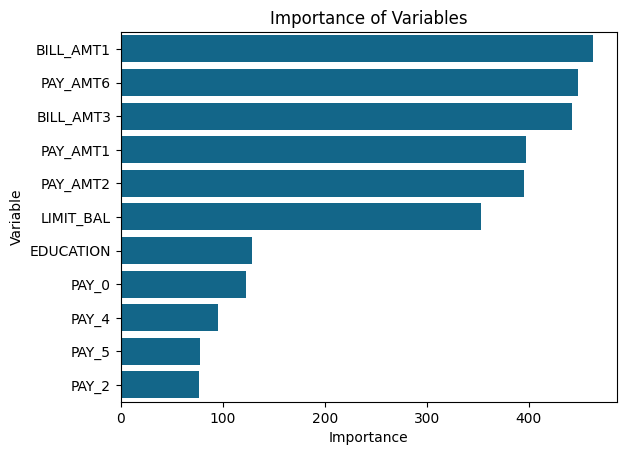

In [95]:
plot_feature_importance(lgbm)

### Permutation Importance

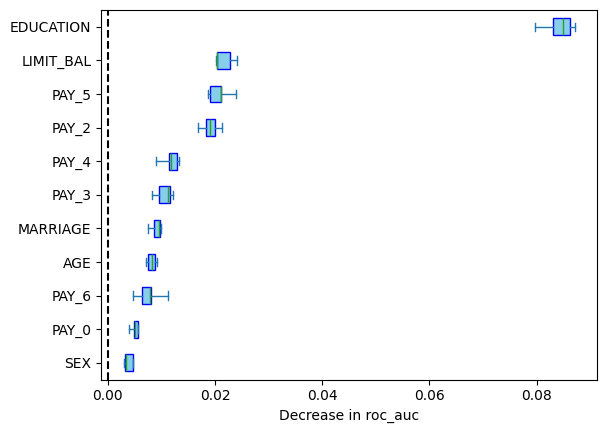

In [96]:
plot_permutation_importance(model=lgbm, features=selected_columns, X=X_test, y=y_test['target'], scoring='roc_auc')

### SHAP Values

/home/junior/Documentos/palestra_scti/venv/lib64/python3.10/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/tmp/ipykernel_4796/968569990.py:109: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X[features])


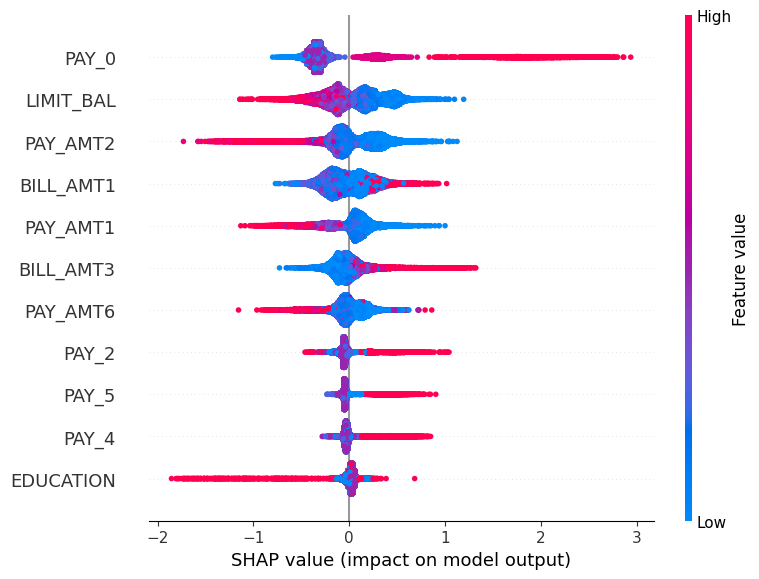

In [97]:
plot_shap_summary(lgbm, selected_columns, X)

### Score Analysis

In [115]:
y_train['score'] = prob_to_score(y_train['prob'], inverse=True)
y_test['score'] = prob_to_score(y_test['prob'], inverse=True)

In [116]:
thresholds = calc_rating_limits(y_train['score'])
y_train['rating'] = apply_ratings(y_train['score'], thresholds)

In [119]:
thresholds = calc_rating_limits(y_test['score'])
y_test['rating'] = apply_ratings(y_test['score'], thresholds)

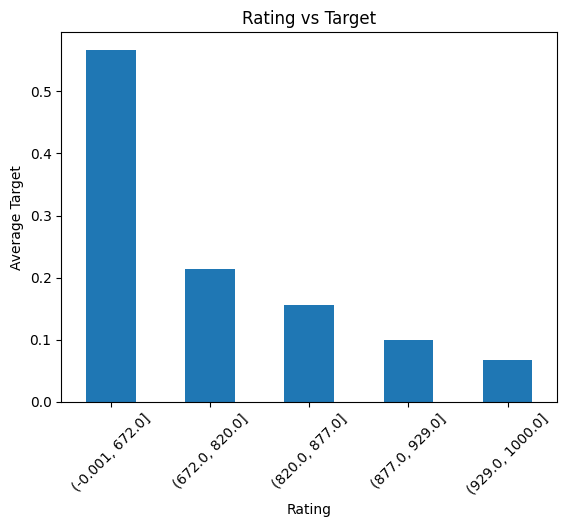

In [120]:
plot_rating(y_test, 'target')

## Hyper-parameter Tuning Model

Bicliotecas:
- [Scikit-Learn](https://scikit-learn.org/stable/api/sklearn.model_selection.html)
- [Optuna](https://optuna.org/)

# Deploy